# CMSE 201 Project - Probabilistic Fortnite Simulations
### Grant Wiese
### Section 002

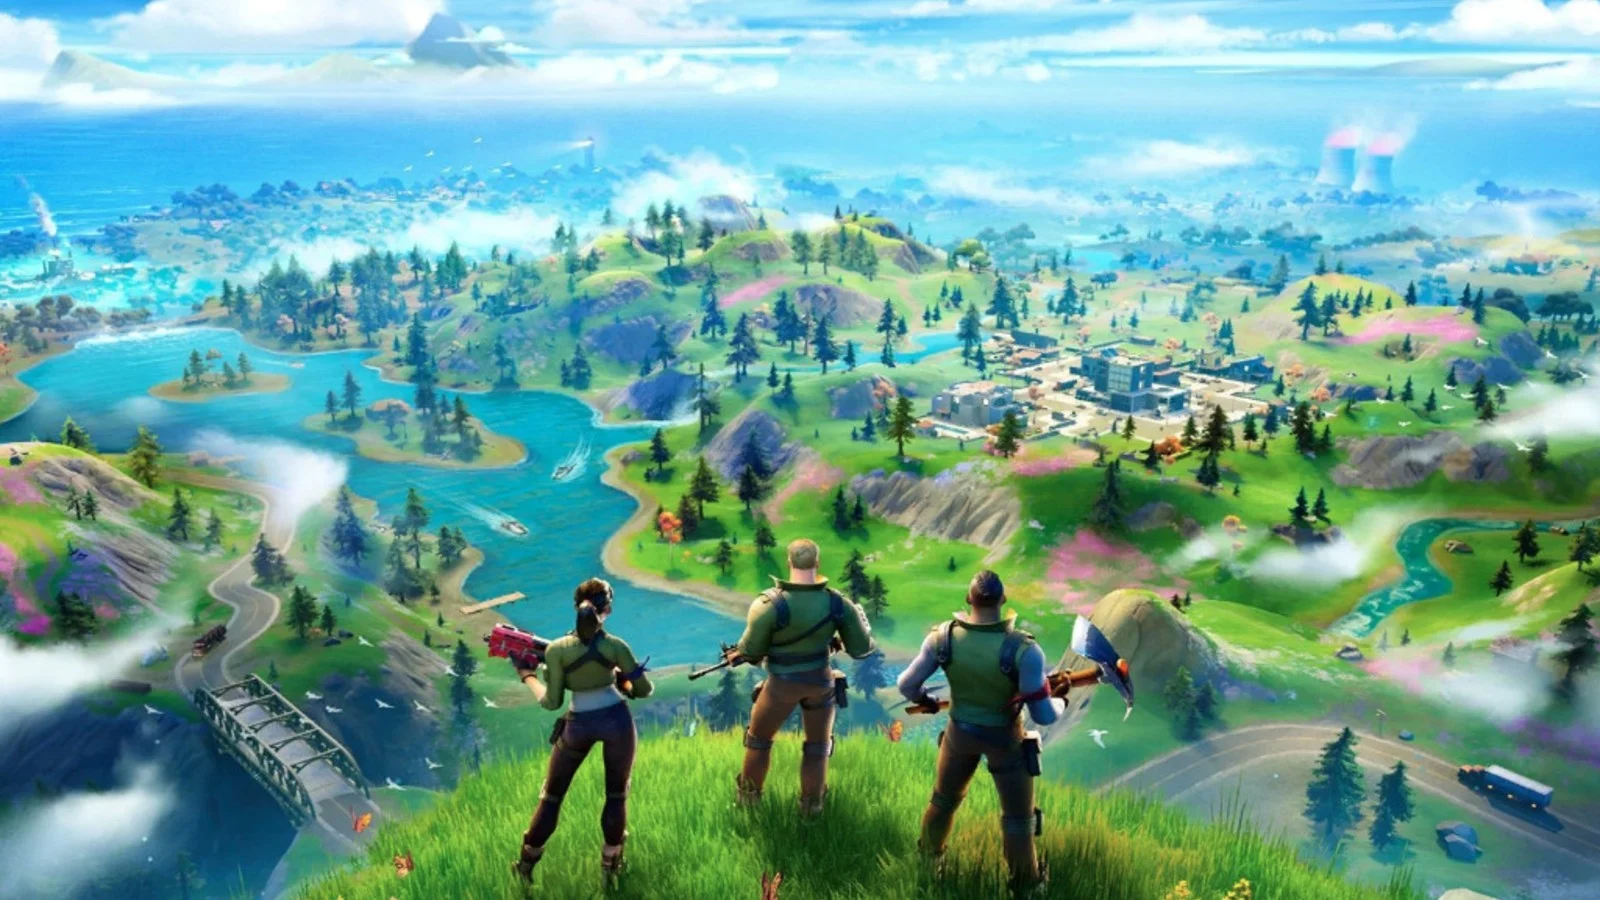

### Introduction: Motivation

In CMSE 201, we have learned how to use different types of models to approximate behavior, patterns, and anomolies in data. In my project, I wanted to combine some of the things that we have used in this class to utilize a different type of modeling. I wanted to use randomness and probabilites to simulate complex behaviors that would be hard to quickly do with agent based models. 

At first as a joke that got progressivley more and more serious, I thought that it would be interesting to simulate Fortnite games with this type of modeling. In order to reel in this idea to levels that were atainable in my given time frame, I decided to focus on three variables in my simulation. Accuracy, prevous game rounds played, and shooter game expereince. The first part of this project wll walk through the details of how the simulation works, then in the second half - we will explore the data that is returned by the simulation

### Wait... what's Fortnite?

# Section A - Methodology: Probability Simulation 

### A.1 Import Packages

In [128]:
#Import Packages
import numpy as np
import random as rnd
import matplotlib.pyplot as plt  
import seaborn as sns
import copy
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

### A.2 Simulating one game

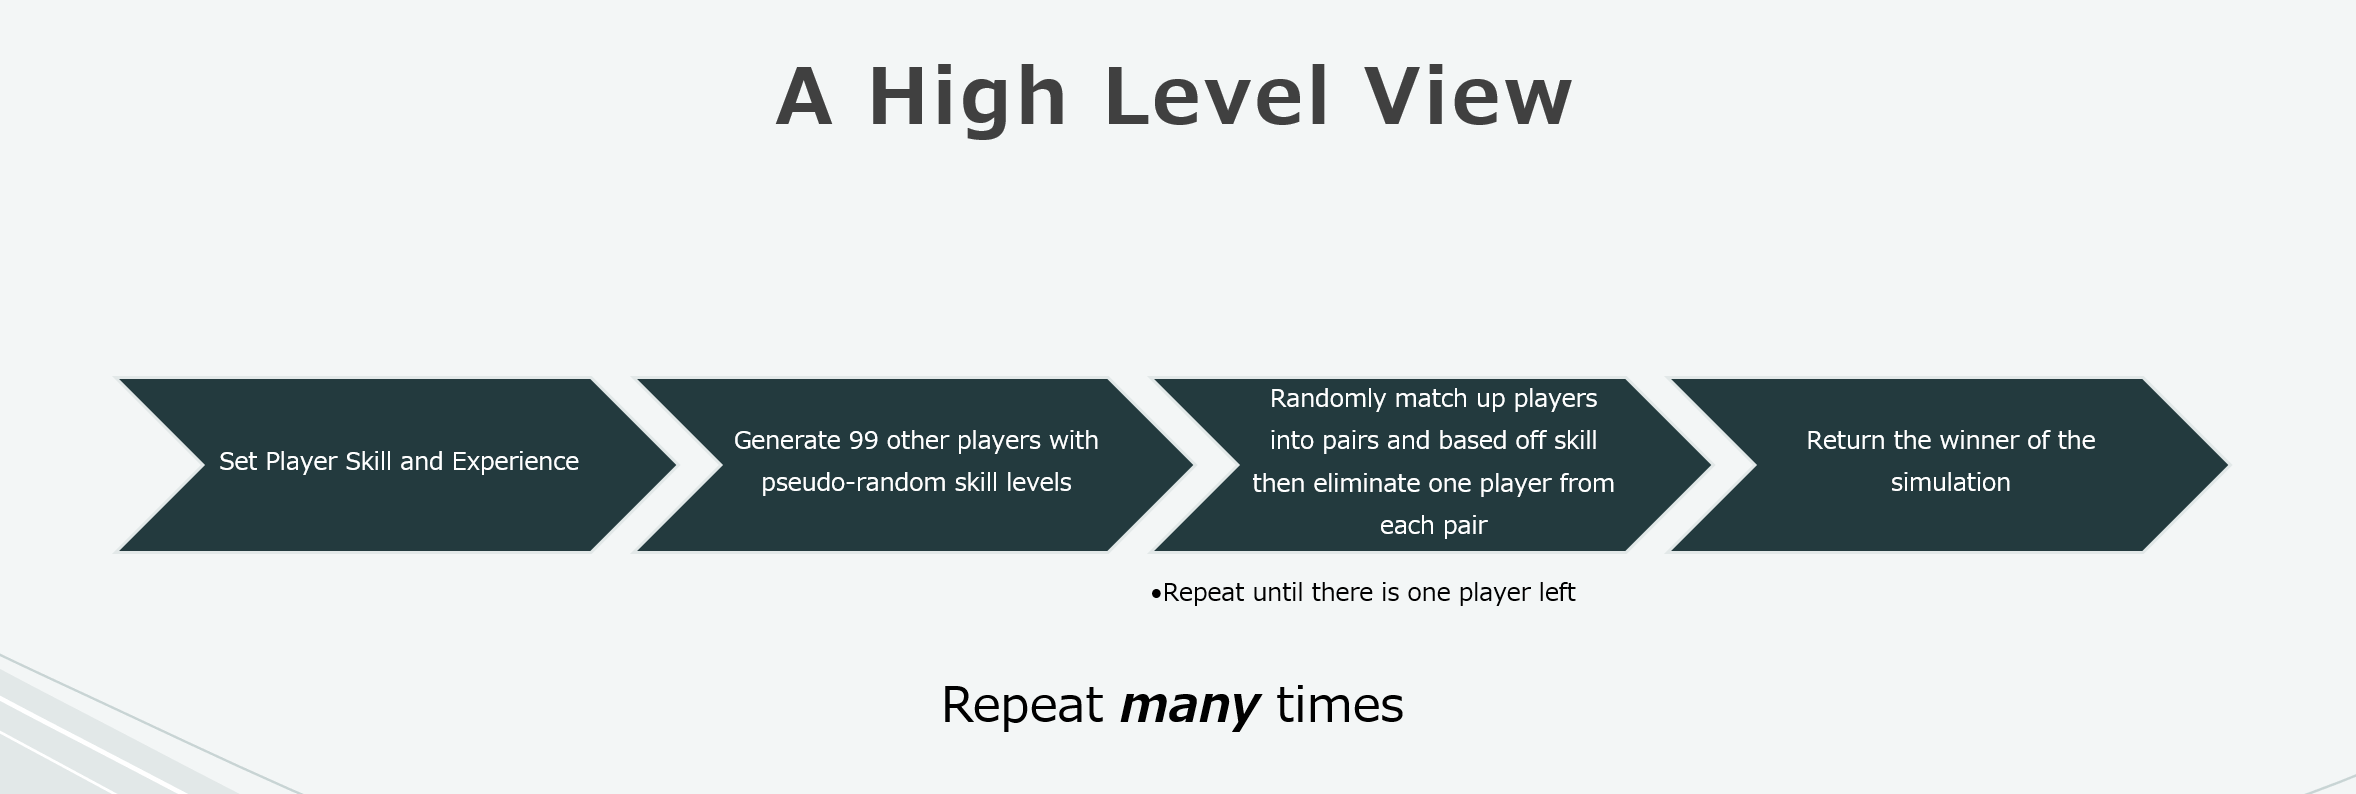

The above image shows the high level overview of how one simulation would work, it obviously skips over a lot of the important details, but it conveys the essence of the core simulation functions. 

1. Set player skill and expereince
2. Generate 99 other players with pseudo random skill levels
3. Randomply match up players into pairs and based off skill then eliminate one player from each pair
4. Repeat above step until there is only one player remaining
5. Return the winner of the simulation.


### A.2.1 Set player skill

In [94]:
# ["player", [Acc,Games,Exp]] This is the format of how the functions will take a user defined player. Referenced as Block

- The first part of the big list contains a string of characters that serve as that package's "ID", for the player that you define, this will always be set to "player"
- The second part of the list is another list that contains the player's paramaters that we define.

[X,o,o] The first part of this list is the accuracy percentage that we want the player to have, this can be any float between the interval of 0 to 1. I included accuracy as this seems to be one of the most important statistics in a game like Fortnite. The more shots that you can land on your opponets, the more quickly you can end the engagement and avoid taking damage.

[o,X,o] The second part of this list is the number of previous rounds the player has played, this can be set to any integer in the range of 0 to infinity. I chose to use this statistic because the more you play a game, the better you get at it. It seemed obvious to include this in the simulation as it is representative of skill, and can be used to easily model skill growth.

[o,o,X] The last part of the list is the number of shooter games the player has played before in their life. This can be set as an integer between 0 and infinity. I didnt really know if I should incude this variable at first, but as I experimented with  the code, I realized that I needed more variance in my outcomes - thus adding this variable seemed like the natural choice.

### A.2.2 Generate other players

This next part is where we generate other players for the simulations. We will want to call this main function every time we simulate a new game to generate new players every game.

Generate_players takes 3 different distributions of parameters returned by generate_dists and randomly assigns a value from each distribution to their parameter block, along with a unique reference ID.

In [95]:
def generate_players(alphas,sigmas,deltas,n=99):
    # Generates n players with pseudo random params based off of generate_dists chain and assigns each player unique reference ID
    # Call beginning of each game
    ID = 0
    master = []
    for i in range(1,n+1):
        alpha = rnd.choice(alphas)
        sigma = rnd.choice(sigmas)
        delta = rnd.choice(deltas)
        data = [[i],[alpha,sigma,delta]] # Standard player data block format
        master.append(data)
        ID =+ 1
    return master

Generate_dists creates 3 distributions of 10000 values for each parameter using gammavariate and gauss random number generators. This ensures that most players will have a mean value for each parameter, with the probability of selecting an extreme number exponentially decrease as the standard deviation from the mean increases. 

The following histograms show the distributions of how the random number generatiors created the numbers.  

In [96]:
def generate_dists():
    # Generates distributions of 10000 values for each parameter. Should only be called once per sim of sims
    alpha = []
    sigma = []
    delta = []
    for i in range(10000):
        temp = rnd.gammavariate(2,.1)
        if temp <= 1: #No hackers!
            alpha.append(temp)
        temp = rnd.gauss(200, 50) #mean, sd
        if temp >= 0: #Ensuring the random number generator will not return < 0 values as playing negative games would not make sense
            sigma.append(round(temp))
        temp = rnd.gammavariate(3,1.5)
        delta.append(round(temp))
    return alpha, sigma, delta

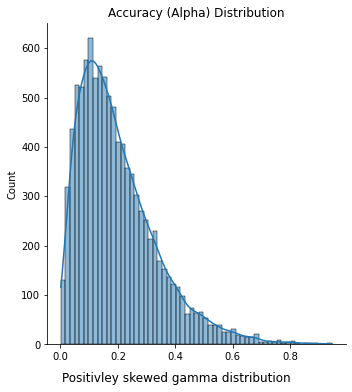

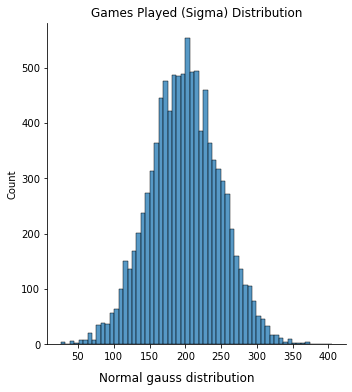

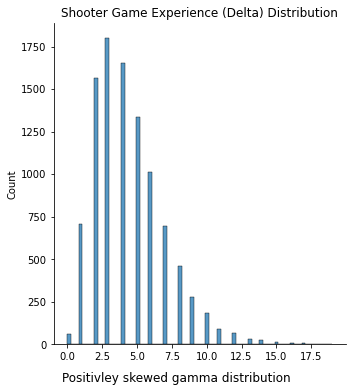

In [143]:
rnd.seed(214)
alphas,sigmas,deltas = generate_dists()

sns.displot(alphas, kde=True)
plt.title('Accuracy (Alpha) Distribution')
txt="Positivley skewed gamma distribution"
plt.figtext(.5, 0.001, txt, wrap=True, ha='center', va = 'top', fontsize=12)

sns.displot(sigmas)
plt.title('Games Played (Sigma) Distribution')
txt="Normal gauss distribution"
plt.figtext(.5, 0.001, txt, wrap=True, ha='center', va = 'top', fontsize=12)


sns.displot(deltas)
plt.title('Shooter Game Experience (Delta) Distribution')
txt="Positivley skewed gamma distribution"
plt.figtext(.5, 0.001, txt, wrap=True, ha='center', va = 'top', fontsize=12)


plt.show()

### A.2.3 Group and eliminate players

There functions are where the logic of the simulations is held. The code chunk below takes a list of the generated players and the user defined player and randomply groups them into pairs of two. If there is an odd number of players, the function randomly eliminates one player that is NOT the user defined player. 

In early development, this function was dificult to control as it did not create individual memory locations for each variables, and tended to misbehave. This is why the diagnostic function exists. It checks the output of group up and looks for grouping errors, value errors, and blocks that should not be there. However after more development I have eventually ironed out all bugs from the group_up function! However I wanted to keep the diagnostic function as it is very polite.

In [98]:
def group_up(loc_population):
    # Takes list of players returned by generate_players and test player, then randomly sorts players into groups of 2
    # If total number of players is odd, deletes a random generated player then proceeds normally
    my_list = loc_population
    rnd.shuffle(my_list)
    master = []
    split0 = []
    split1 = []
    if len(my_list) % 2 == 0:
        for x in range(0,len(my_list),2):
            split0.append(my_list[x])
        for x in range(1,len(my_list),2):
            split1.append(my_list[x])
        for x in range(0,len(split0)):
            master.append([split0[x],split1[x]])
        return master
    else:
        #print('Length not divisible by 2. Removing a randomly generated player')
        search = True
        while search == True:
            pop_index = rnd.randint(0,len(my_list)-1)
            if my_list[pop_index][0] != 'player':
                #print('Removed ID:', my_list[pop_index][0])
                my_list.pop(pop_index)
                search = False
        for x in range(0,len(my_list),2):
            split0.append(my_list[x])
        for x in range(1,len(my_list),2):
            split1.append(my_list[x])
        for x in range(0,len(split0)):
            master.append([split0[x],split1[x]])
        return master
        
        

In [99]:
def diagnostic(x):
    # Checks structure of list returned by group_up
    # prints error if groups do not have exactly two items
    # prints error if player ID is found more then once
    errors = []
    checked_ID = []
    for item in x:
        if len(item) != 2:
            errors.append(['Unexpected length error',len(item), item])
        for player in item:
            if (player[0] in checked_ID) == True:
                errors.append(['Double ID error for ID:',player[0]])
                checked_ID.append(player[0])
            else:
                checked_ID.append(player[0])
    if len(errors) == 0:
        print('Woohoo no errors! （＾O＾）')
    else:
        print('There are',len(errors),'errors')
        for e in errors:
            print(e)
    #To-do: Add ability to check more then one type of structure
            
    
    

This is where it gets interesting, eliminate is a scary sounding function that takes the output from group_up and then passes each pair of groups through get_win_packed which then returns the winner based off of weighted probabilites from get_win. This is a lot to unpack, but reading through some of the comments in eliminate, the rapid tossing of blocks to each function makes sense to group up players, eliminate player each round, regroup, eliminate, regroup, eliminate.... return winner! 

In [100]:
def eliminate(group, count = 100): # Eliminates one of each pair through get_win_packed chain, then checks if player is still in. 
    # If player is eliminated, passes True and iteration which the player was eliminated
    master = []
    eliminated_count = count
    player_won = 0
    for pair in group:
        if ('player' in pair[0][0]) == True or ('player' in pair[1][0]) == True:
            check = get_win_packed(pair)
            if ('player' in check[0]) == False:
                player_won = False
                eliminated_count -= 1
                return [player_won, eliminated_count]
            else:
                eliminated_count -= 1
                master.append(check)
        else:
            eliminated_count -= 1
            master.append(get_win_packed(pair))
    if len(master) == 1 and master[0][0] == 'player':
        player_won = True
        return player_won
    return [master, eliminated_count]

In [101]:
def get_win_packed(group): #Takes packed input returned by group_up, to be used by eliminate
    # Calculates skill from get_score, creates probabilities of winning for each player, then returns winner 
    p1skill = get_score(group[0][1])
    p2skill = get_score(group[1][1])
    chances = ((x/(p2skill+p1skill)) for x in [p1skill,p2skill])
    winner = rnd.choices([group[0],group[1]], weights = chances)
    return winner[0]

Get score and get win is the most mathy part of the project to develop. I had to create a function that would generate some score that responds to each variable in a different way. However, this is where the parameters get combined and calculated into a number thats necessary for creating a probability.

- Delta = FPS Experience [0,inf)
- Sigma = Game Expereince [0,inf)
- Alpha = Accuracy (0,1)



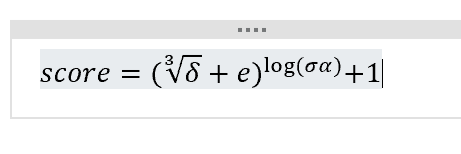

The above equation approximates a linear equation with a slight log increase at low scores. Its designed to take games played as the basis of score determination which is reduced by alpha, then slightly augmented by delta. Then it adds one to a score in order for extreme low scores to be able to have a nonzero probability of winning. 

If this does not make sense, dont worry - we will see the effects of this equation in the analysis portion of the writeup.

In [102]:
def get_score(x):
    alpha,sigma,delta, = x # Unpack player params
    result = ((np.cbrt(delta)+np.e)**(np.log10(sigma*alpha)))+1 # Apply above equation
    return result # Return computed score

def get_win(p1,p2):
    # Calculates skill from get_score, creates probabilities of winning for each player, then returns winner 
    p1skill = get_score(p1[1])
    p2skill = get_score(p2[1])
    chances = ((x/(p2skill+p1skill)) for x in [p1skill,p2skill])
    winner = rnd.choices([p1,p2], weights = chances)
    return winner[0]

The below function is a demonstration of how a user defined player's probabilty of winning (which is returned from get_win) stakcs up against 100 other players. I used this as proof to myself that this function works correctly. Since the user defined player has very low initial parameters, the graph returns the expected result of that player returning low p values against the majority of generated players.

In [103]:
def test_vs_a(aval,bval):
    # Gets winning probability of a by simulating get_win chain 1000 times
    # Not to be used in sim
    a = 0
    b = 0
    for x in range(1000):
        z = get_win(aval,bval)[0]
        if z == "player":
            a += 1
        else:
            b += 1
    return(a/(a+b))

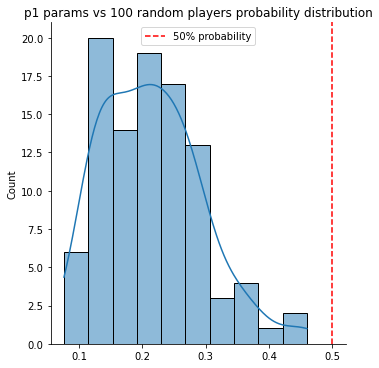

In [124]:
# Viz of winning probabilites returned from test_v_a chain with user defined player
rnd.seed(214)
alphas,sigmas,deltas = generate_dists()
mans = ["player", [.01,200,1]]
p2 = generate_players(alphas,sigmas,deltas,n=99)
data = []
for x in p2:
    data.append(test_vs_a(mans,x))
sns.displot(data, kde=True, bins = 10)
plt.axvline(x=0.5, color = 'red', linestyle = 'dashed', label = '50% probability')
plt.title("p1 params vs 100 random players probability distribution")
plt.legend()
plt.show()


### A.2.4 Return Winner (and engine of simulation)

The simulate game function serves as the engine of the simulation. It creates the roster that is passed to all of the above functions and finds the winner of the simulations. If the winner is the user defined player, then it passes a message that the player has won that simulation. Woohoo! It also returns useful statistics that can be used by funtions that are higher up on the stack such as when the player was eliminated, and the parameters of the eliminated player.

In [105]:
def simulate_game(player,alpha,sigma,delta):
    roster = generate_players(alpha,sigma,delta) # Generate 99 random players to roster list
    roster.append(player) # Append player block to the roster
    player_eliminated = False
    count = 100
    while player_eliminated == False: # Loop until player is eliminated
        roster = group_up(roster)
        outcome = eliminate(roster, count)
        if outcome == True:
            player_eliminated == True
            return ('Player has won a game') # Player has won message
        if outcome[0] == False:
            player_eliminated == True
            return outcome # Return useful outcome statistics
        else:
            count = outcome[1]  # Sets count to the players 
            roster = outcome[0] # Sets roster to the players left standing

### A.3 Higher order functions

These functions are designed to run simulate_game many times to generate interesting statistics to analyze. simtillwin is a function that runs the simulation until the player eventually wins a game. While sim_ntimes suprisingly runs the simulation an n number of times. Both are used in the analysis portion of writeup and presentation.

In [106]:
def simtillwin(player):
    alpha,sigma,delta = generate_dists()
    simcount = 0
    playerstats = copy.deepcopy(player) # = is not copy, but reference in memory. Use deepcopy to create discrete repositories 
    record = []
    while True:
        outcome = simulate_game(playerstats,alpha,sigma,delta)
        if outcome == 'Player has won a game':
            return simcount,playerstats, record
        else:
            record.append(outcome[1])
            simcount += 1
            playerstats[1][1] += 1
            

In [107]:
def sim_ntimes(player,n):
    alpha,sigma,delta = generate_dists()
    simcount = 0
    wins = 0
    playerstats = copy.deepcopy(player) # = is not copy, but reference in memory. Use deepcopy to create discrete repositories 
    record = []
    for x in range(0,n):
        outcome = simulate_game(playerstats,alpha,sigma,delta)
        if outcome == 'Player has won a game':
            record.append(0)
            simcount += 1
            wins += 1
        else:
            record.append(outcome[1])
            simcount += 1
    win_prob = wins/simcount
    return simcount,playerstats, record, wins, win_prob
            

Stats is a super meta function that runs simtillwin an n amount of times. This results in very high computation times, and interesting analysis.

In [108]:
def stats(player, sims):
    params = player
    master = []
    for x in range(0,sims):
        master.append(simtillwin(params)[0])
    return master

# Section B - Analysis: Finding Meaning 

### B.1 Research Questions

##### 1. How do player statistics change with different player parameters

Through this question, I want to look at the effect of how accuracy, shooter game experience, and Fortnite experience affect the overall probability of a player winning simulations. 

##### 2. How does skill growth affect the probability of winning over n simulations. 

In the simulation, for every simulation, the user defined player's Fortnite experience increases by one. I want to see the effect of this skill growth and how it affects the player's chances at winning.

### B.2.1 Parameter Analysis

To answer this research question, I'll need to use the sim_ntimes function in order to create accurate probabilities to base my analysis off of. Then I will create an array of possible player values to feed into this function with two parameters that are set constant, while the test parameter changes. This will allow us to see the effect of that changing parameter on the probability of winning.

In [109]:
rnd.seed(214)
acc_dist = np.linspace(.05,.95,15)
prob_list = []
for x in acc_dist:
    p1 = ["player", [x,250,5]]
    simcount,playerstats, record, wins, win_prob = sim_ntimes(p1, 5000)
    prob_list.append(win_prob)
    

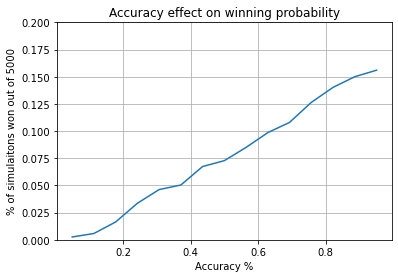

In [110]:
plt.plot(acc_dist, prob_list)
plt.xlabel("Accuracy %")
plt.ylabel("% of simulaitons won out of 5000")
plt.title("Accuracy effect on winning probability")
plt.ylim(0,.20)
plt.grid()


The above graph shows that with player parameters set to:

- 250 Previous Games Played, with normal growth enabled
- 5 FPS game experience
- Array of 15 different accuracy values between 0 and 1
- 5000 simulations per x

There is a significant relationship between accuracy and the probability of this player winning a game of Fortnite. This is to be expected as when accuracy approaches a perfect 1, the probability of winning also increases significantly. The p value on the y axis is also a prepresentation of the probability of that player winning any simulation given these parameters.

In [111]:
rnd.seed(214)
game_dist = np.linspace(10,500,50)
gprob_list = []
for x in game_dist:
    p1 = ["player", [.15,int(x),5]]
    simcount,playerstats, record, wins, win_prob = sim_ntimes(p1, 1000)
    gprob_list.append(win_prob)
    

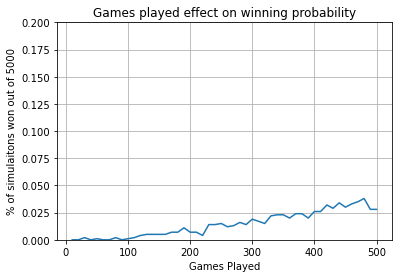

In [112]:
plt.plot(game_dist, gprob_list)
plt.xlabel("Games Played")
plt.ylabel("% of simulaitons won out of 5000")
plt.title("Games played effect on winning probability")
plt.ylim(0,.2)
plt.grid()


The above graph shows that with player parameters set to:

- 15% Accuracy
- 5 FPS game experience
- Array of 50 different games played values between 0 and 500
- 1000 simulations per x

There is a significant relationship between games played and the probability of this player winning a game of Fortnite, albeit smaller then the relationship with player accuracy. When looking back to the equation in the get_win function, this relationship makes sense. Games played is the basis of the equation, however accuracy can greatly reduce this number - showing that accuaracy has a greater effect on the probability score then past games played. 

In [113]:
rnd.seed(214)
exp_dist = np.linspace(0,25,20)
xprob_list = []
for x in exp_dist:
    p1 = ["player", [.15,250, int(x)]]
    simcount,playerstats, record, wins, win_prob = sim_ntimes(p1, 1000)
    xprob_list.append(win_prob)
    

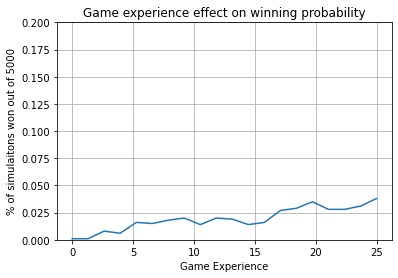

In [114]:
plt.plot(exp_dist, xprob_list)
plt.xlabel("Game Experience")
plt.ylabel("% of simulaitons won out of 5000")
plt.title("Game experience effect on winning probability")
plt.ylim(0,.2)
plt.grid()


The above graph shows that with player parameters set to:

- 15% Accuracy
- 250 Previous Games Played, with normal growth enabled
- Array of 20 different games played values between 0 and 25
- 1000 simulations per x

When looking at the graph, we can see that previous games have the smallest effect on probability when compared to the other two parameters. This seems to be an accurate behavior, as your experince in other fps games can affect your overall skill, however they dont directly translate into skill as accuracy and games played is more important.

### B.2.2 Skill with Minimum Games

In this second part of the analysis, I wanted to look on the effect of player parameters on the mean amount of minimum games needed to win. We are looking for "good" behavior that indicates that the simulation is indeed working the way we have intended it. This expected behaivor is that players with parameters much greater then the mean will, on average, need to play less games before they win at least once.

In [125]:
rnd.seed(214)
p1 = ["player", [.3,100,5]]
metasim_results = stats(p1, 100)

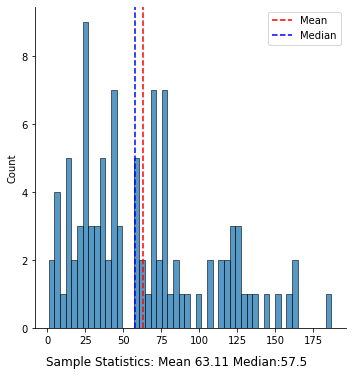

In [129]:
sns.displot(metasim_results, bins = 50)
plt.axvline(x=np.mean(metasim_results), color = 'red', linestyle = 'dashed', label = 'Mean')
plt.axvline(x=np.median(metasim_results), color = 'blue', linestyle = 'dashed', label = 'Median')
txt=("Sample Statistics: Mean " + str(np.mean(metasim_results)) + ' Median:' + str(np.median(metasim_results)))
plt.figtext(.5, 0.001, txt, wrap=True, ha='center', va = 'top', fontsize=12)
plt.legend()

The above graph is a histogram of 100 samples of the minimum simulations it took for the player to win a game for a player with the following parameters.

- 30% Accuracy
- 100 Previous Games Played, with normal growth enabled
- 5 FPS experience

We can see from the graph that a player with these parameters usually takes 63.11 games to get their first win. From this, we can say that it takes a player with these parameters 63.11 games to have a 50% at winning once. However, to conclude on anything about the correct simulation behavior, we will need to compare these results to a highly skilled player.

In [130]:
rnd.seed(214)
p1 = ["player", [.7,400,11]]
metasim_results = stats(p1, 100)

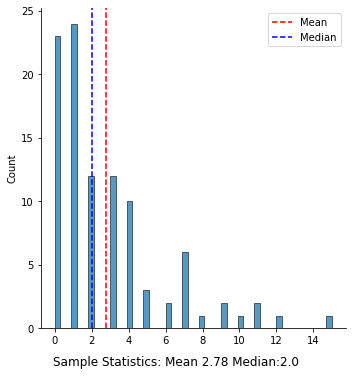

In [131]:
sns.displot(metasim_results, bins = 50)
plt.axvline(x=np.mean(metasim_results), color = 'red', linestyle = 'dashed', label = 'Mean')
plt.axvline(x=np.median(metasim_results), color = 'blue', linestyle = 'dashed', label = 'Median')
txt=("Sample Statistics: Mean " + str(np.mean(metasim_results)) + ' Median:' + str(np.median(metasim_results)))
plt.figtext(.5, 0.001, txt, wrap=True, ha='center', va = 'top', fontsize=12)
plt.legend()

The above graph is a histogram of 100 samples of the minimum simulations it took for the player to win a game for a player with the following parameters.

- 70% Accuracy
- 400 Previous Games Played, with normal growth enabled
- 11 FPS experience

Just by looking at the x axis, we can immedietly tell that there is a big difference between the average player and the highly skilled player. A highly skilled player only needs to play a few games before they win once, on average 2.78 games. When comparing this to the previous grpah, we can see that this is the expected behavior, which means that the simulation is working!

### B.3 Skill growth on outcomes

Modeling skill growth is imporant as this is something happens in real life. Every time you play a round, you learn something new. My simulation reflects this by adding one to the player's parameters for every simulation that the player is put through, reflecting some degree of skill growth. I wanted to measure the effect on skill growth on the player's overall placement. In order to do so, I need to measure the the instance when the player is eliminated every iteration, then try to find a general trend.

It is expected that over the period that you are testing, the average placement of the player decreases, as you are gaining skill every simulation

In [118]:
rnd.seed(214)
p1 = ["player", [.2,20,3]] # Average player
simcount,playerstats, record, wins, win_prob = sim_ntimes(p1,300)

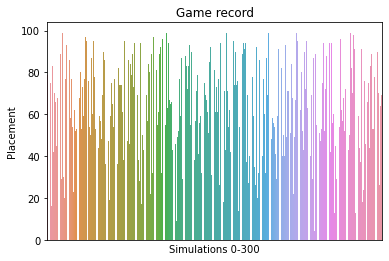

In [119]:
sim = [x for x in range(1,len(record)+1)]
sns.barplot(sim, record)
plt.xlabel('Simulations 0-300')
plt.ylabel('Placement')
plt.title('Game record')
plt.tick_params(axis='x', which='both',bottom=False,labelbottom=False) 

However when looking at the gaph, it does not seem that there is any correlation, it is not only messy but very sparratic. 

In [145]:
a,b = np.polyfit(sim, record, 1)
predict = []
for x in sim:
    predict.append(a*x+b)

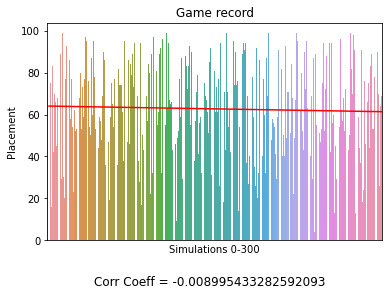

In [146]:
sim = [x for x in range(1,len(record)+1)]
plt.plot(sim, predict, color = "red")
sns.barplot(sim, record)
plt.xlabel('Simulations 0-300')
plt.ylabel('Placement')
plt.title('Game record')
txt=(("Corr Coeff = ") + str(a))
plt.figtext(.5, 0.001, txt, wrap=True, ha='center', va = 'top', fontsize=12)
plt.tick_params(axis='x', which='both',bottom=False,labelbottom=False) 

When running a regression line through the data, it becomes evident that there is no correlaton between skill and placement over time. It seems that the inherent variance built into the simulation overtakes any skill gain by the player over time, so skill growth does not affect the players placement. 

# Section C - Synthesis

### C.1 Is simulating Fortnite possible, what are its limitations.

Yes, simulating a Fortnite game is possible with the way I have set up simulations. I am able to compare three variables and then run them against random combinations of variables millions of times and come up with interesting predictions about future runs. 

However, there are some limitations with the applicability of the model. First of all, my model does not take into account many of the varables that go into an interaction in fortnite including: resources, current weapon, health, shields, teammates, and many more. Additionally, the game takes place in a 3D environment so grouping players randomly up isnt exactly a natural player interaction.

Because of this, I cannot say that my model is very predictive of real fortnite encounters, but it provides an interestign echo of how it may in fact play out. 

### C.2 Answering Research Questions

##### 1. How do player statistics change with different player parameters

From my analysis, I have learned that accuracy plays the biggest role in determining probability of winning, eclipsing both Fortnite experience and FPS experience. I have also found out that running simulations over and over many times leads to the overall probability that a given player will win the next simulation. This allows me to make predictions about how likley a player is to win a game.

I was also able to explore the implications of high skilled player and low skill players on the minimum amount of games it took them to won. Not suprisingly, I found out that high skilled players, on average, took less games to get at least one win when compared to an average player. These findings also served as proof that my function returned the correct behavior as this is the expected outcome of normal Fortnite games.

##### 2. How does skill growth affect the probability of winning over n simulations. 

When modeling simple skill growth in the simulation, I wanted to see if there was a significant effect on player's placement over games. I learned that the variance of placements over a set number of simulations does not reflect skill growth. We know that skill growth does in fact increase the overall probability of winning from the previous question, but there is too much oice introduced by random players to tell if it increases player placements.  

### C.3 What I would do Differently

This project was really interesting to do, and I genuinely enjoyed creating the functions and trying to get the simple simulations to actually work. I thought that this was a really cool application of my coding knowledge that I have learned entirely in this class.

However, I bit off more then I could realistically chew, there was a lot to do and talk about, so I could not realistically cover it all in the short time I gave myself to work on it. If I had more time and more freedom to increase the complexity of the simulation, this notebook (and synthesis sections) would be much more detailed then they are right now. 